# Dimensionality Reduction

Here is the third part and it is about dimentionality reduction. How to map high-dimentional data into low-dimensional space is an interesting topic in machine learning field. And also, it is related to another hot topic -- unsupervised learning. Now, in this section, you are going to learn two different methods for this question.

* Principal Component Analysis (PCA)
* t-Distributed Stochastic Neighbor Embedding (t-SNE) 

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from hw1.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

## Load Data

We will use the CIFAR-10 dataset.

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 is this 100 or 1000?
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(49000, 32, 32, 3) (1000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development data shape (100,)


## Part 1: Principal Component Analysis (PCA)


### Naive PCA

In [3]:
from hw1.features.pca import pca_naive

X_patch = X_train[:,:,:,0]
X_patch = np.reshape(X_patch, (X_patch.shape[0], -1))

In [4]:
# Start PCA
K = 200
P, T = pca_naive(X_patch, K)

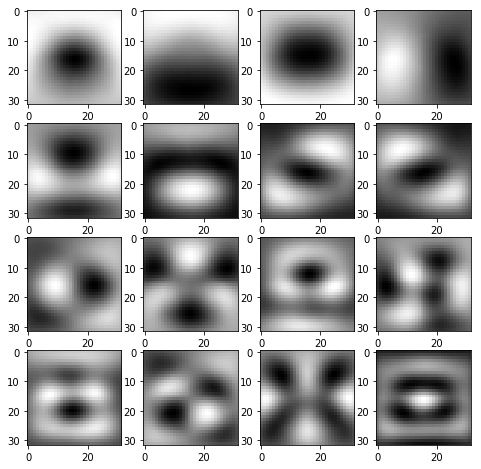

In [5]:
# Visualize P
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = np.reshape(P[r*i+j], [32,32])
        axarr[i][j].imshow(img, cmap="gray")

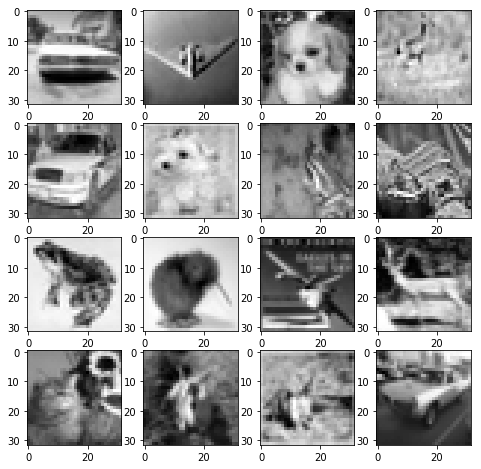

In [6]:
# Select a small set of images for test
num_training = 50000
num_pca = 16
mask = np.random.choice(num_training, num_pca, replace=False)
X_pca = X_train[mask,:,:,0]

# Visualize one channel of images 
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_pca[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

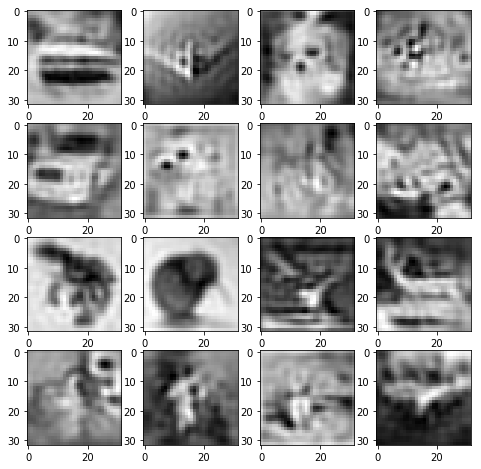

In [7]:
# Reduce dimension with P
X_features = []
for n in range(num_pca):
    img = X_pca[n]
    feature = np.dot(P, np.reshape(img, (-1,)))
    X_features.append(feature)

# Reconstruct image
X_recon = []
for n in range(num_pca):
    feature = X_features[n]
    img = np.reshape(np.dot(feature, P), (32,32))
    X_recon.append(img)

# Visualize results
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_recon[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

### PCA + Neural network

Use PCA to preprocess images before training a neural network: 

1. Do PCA preprocessing on each channel of the original image separately.
2. Stack PCA features from three channels into one vector, and use that vector as an input for MLP.
3. Train the MLP and show the results. 

In [10]:
from hw1.train_funcs import train, test
from hw1.classifiers.mlp import MLP


for i in range(3):
    
    #Loading data
    temp1 = X_train[:,:,:,i]
    temp2 = X_val[:,:,:,i]
    temp3 = X_test[:,:,:,i]
       
    #Reshaping it to 1024
    temp1_new = np.reshape(temp1, (temp1.shape[0], -1))
    temp2_new = np.reshape(temp2, (temp2.shape[0], -1))
    temp3_new = np.reshape(temp3, (temp3.shape[0], -1))
    
    #Printing shapes
    print("Flatten shapes")
    print(temp1_new.shape)
    print(temp2_new.shape)
    print(temp3_new.shape)
    
    #Finding P and T on train data
    K = 200
    P_1, T_1 = pca_naive(temp1_new, K)
    
    #Reducing dimensions
    redu_train = temp1_new.dot(P_1.T)
    redu_val = temp2_new.dot(P_1.T)
    redu_test = temp3_new.dot(P_1.T)
    
    print("Reduced shapes")
    print(redu_train.shape)
    print(redu_val.shape)
    print(redu_test.shape)
    
    if i==0:
        new_train = redu_train
        new_val = redu_val
        new_test = redu_test
    else:
        new_train = np.concatenate((new_train, redu_train), axis=1)
        new_val = np.concatenate((new_val, redu_val), axis=1)
        new_test = np.concatenate((new_test, redu_test), axis=1)

print("Concatenate shapes")
print(new_train.shape)
print(new_val.shape)
print(new_test.shape)

model = MLP(input_dim=600, hidden_dims=[100, 50], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = True
train_acc_hist, val_acc_hist = train(model, new_train, y_train, new_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test_acc = test(model, new_test, y_test)
# pca preprocessing -> mlp classification

Flatten shapes
(49000, 1024)
(1000, 1024)
(10000, 1024)
Reduced shapes
(49000, 200)
(1000, 200)
(10000, 200)
Flatten shapes
(49000, 1024)
(1000, 1024)
(10000, 1024)
Reduced shapes
(49000, 200)
(1000, 200)
(10000, 200)
Flatten shapes
(49000, 1024)
(1000, 1024)
(10000, 1024)
Reduced shapes
(49000, 200)
(1000, 200)
(10000, 200)
Concatenate shapes
(49000, 600)
(1000, 600)
(10000, 600)
number of batches for training: 98
5000/49000 loss: 2.3036279475901824
10000/49000 loss: 2.3035317960577433
15000/49000 loss: 2.3034952022834903
20000/49000 loss: 2.3033678274101232
25000/49000 loss: 2.3028760908518566
30000/49000 loss: 2.3018776541394237
35000/49000 loss: 2.299905612130461
40000/49000 loss: 2.28893440903583
45000/49000 loss: 2.2264799805806863
epoch 1: valid acc = 0.164, new learning rate = 0.0095
5000/49000 loss: 2.1566259691518375
10000/49000 loss: 2.176679326734565
15000/49000 loss: 2.199680346407196
20000/49000 loss: 2.178850220690695
25000/49000 loss: 2.189720577077038
30000/49000 loss:

Plot training, validation and test set accuracy.

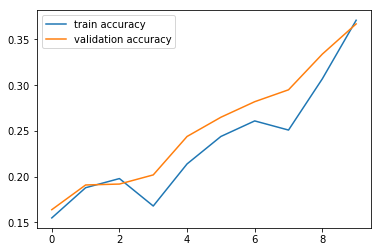

Test accu: 0.3618


In [12]:
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()
print("Test accu:", test_acc)

## Part 2: t-SNE

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR10. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [13]:
from hw1.features.tsne import tsne

#### tSNE of original data

In [14]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test[random_select,:,:,0].reshape(500,1024).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.5107436966
The 100 th loop cost: 14.781496442439739, computation time: 1.3013346195220947
The 200 th loop cost: 1.1465907201984444, computation time: 2.687074661254883
The 300 th loop cost: 1.1419821909564163, computation time: 4.0221405029296875
The 400 th loop cost: 1.1419323899917553, computation time: 5.357293128967285
The 500 th loop cost: 1.1419323002415132, computation time: 6.794821500778198
The 600 th loop cost: 1.1419323000734518, computation time: 8.113464832305908
The 700 th loop cost: 1.1419323000731016, computation time: 9.396414518356323
The 800 th loop cost: 1.141932300073099, computation time: 10.66944408416748
The 900 th loop cost: 1.1419323000730992, computation time: 11.952398300170898
The 1000 th loop cost: 1.1419323000730988, computation time: 13.267554521560669
it takes 13.887765407562256 seconds


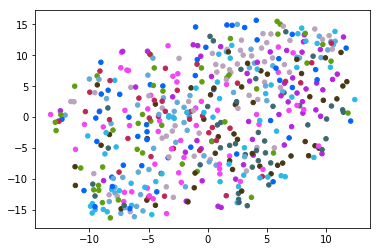

In [15]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, the tSNE of data after two-layer networks is shown as multiple clusters in a 2D panel.

In [17]:
# Define MLP model
model = MLP(input_dim=3072, hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245
epoch 1: valid acc = 0.41, new learning rate = 0.00095
epoch 2: valid acc = 0.462, new learning rate = 0.0009025
epoch 3: valid acc = 0.491, new learning rate = 0.000857375
epoch 4: valid acc = 0.502, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.523, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.519, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.53, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.529, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.536, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.543, new learning rate = 0.0005987369392383785
test acc: 0.5033


0.50329999999999997

In [18]:
# run tSNE
X = X_test[random_select]
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X)
X_exp = np.exp(X)
X = X_exp / np.tile(np.sum(X_exp, axis=1, keepdims=True), 10)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

0.198182382342
The 100 th loop cost: 11.010157781080828, computation time: 1.3275361061096191
The 200 th loop cost: 0.4812244393048363, computation time: 2.7132205963134766
The 300 th loop cost: 0.4662269413953978, computation time: 4.098405838012695
The 400 th loop cost: 0.4649296145333815, computation time: 5.556281089782715
The 500 th loop cost: 0.4647983491645606, computation time: 6.909037113189697
The 600 th loop cost: 0.464778970583851, computation time: 8.228546142578125
The 700 th loop cost: 0.46477578964403626, computation time: 9.541537523269653
The 800 th loop cost: 0.46477523760872014, computation time: 10.86154842376709
The 900 th loop cost: 0.46477514047555096, computation time: 12.179052114486694
The 1000 th loop cost: 0.46477512274184796, computation time: 13.49655532836914
it takes 13.950262308120728 seconds


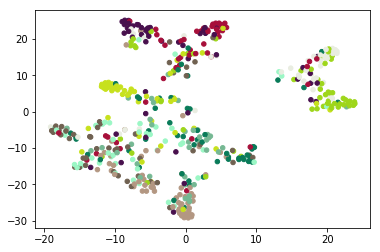

In [19]:
# visualize tSNE 2D representation of data after two hidden layers
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()